https://www.statsmodels.org/stable/vector_ar.html

In [1]:
import arviz as az
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import numpyro
import numpyro.distributions as dist
import pandas as pd
import statsmodels.api as sm
from jax import random
from jaxtyping import Array, Float
from numpyro.contrib.control_flow import scan
from numpyro.handlers import condition
from numpyro.infer import MCMC, NUTS
from statsmodels.tsa.api import VAR
from statsmodels.tsa.base.datetools import dates_from_str

numpyro.set_host_device_count(n=10)

rng_key = random.PRNGKey(seed=42)

az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

%load_ext autoreload
%autoreload 2
# %load_ext jaxtyping
# %jaxtyping.typechecker beartype.beartype
%config InlineBackend.figure_format = "retina"

In [2]:
mdata = sm.datasets.macrodata.load_pandas().data

# prepare the dates index
dates = mdata[["year", "quarter"]].astype(int).astype(str)

quarterly = dates["year"] + "Q" + dates["quarter"]

quarterly = dates_from_str(quarterly)

mdata = mdata[["realgdp", "realcons", "realinv"]]

mdata.index = pd.DatetimeIndex(quarterly, freq="QE")

data = np.log(mdata).diff().dropna()

data.head()

,realgdp,realcons,realinv
1959-06-30,0.024942,0.015286,0.080213
1959-09-30,-0.001193,0.010386,-0.072131
1959-12-31,0.003495,0.001084,0.034425
1960-03-31,0.022190,0.009534,0.102664
1960-06-30,-0.004685,0.012572,-0.106694


In [3]:
var_model = VAR(data)

var_results = var_model.fit(maxlags=2)

var_results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 02, Oct, 2025
Time:                     14:41:16
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -27.5830
Nobs:                     200.000    HQIC:                  -27.7892
Log likelihood:           1962.57    FPE:                7.42129e-13
AIC:                     -27.9293    Det(Omega_mle):     6.69358e-13
--------------------------------------------------------------------
Results for equation realgdp
                 coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------
const               0.001527         0.001119            1.365           0.172
L1.realgdp         -0.279435         0.169663           -1.647           0.100
L1.realcons         0.675016         0.131285            5.142    

In [4]:
y = jnp.array(data)

In [5]:
n_vars = data.shape[1]
n_lags = 2

phi = jnp.arange(n_lags * n_vars * n_vars).reshape(n_lags, n_vars, n_vars)

phi

Array([[[ 0,  1,  2],
        [ 3,  4,  5],
        [ 6,  7,  8]],

       [[ 9, 10, 11],
        [12, 13, 14],
        [15, 16, 17]]], dtype=int32)

In [6]:
y_lags = 2 * jnp.ones((n_lags, n_vars))

y_lags

Array([[2., 2., 2.],
       [2., 2., 2.]], dtype=float32)

In [7]:
(phi * y_lags[..., jnp.newaxis]).sum(axis=(0, 2))

Array([ 66., 102., 138.], dtype=float32)

In [8]:
jnp.einsum("lij,lj->i", phi, y_lags)

Array([ 66., 102., 138.], dtype=float32)

In [9]:
def model(
    y: Float[Array, "time vars"], n_lags: int
) -> Float[Array, "time_minus_n_lags vars"]:
    n_time, n_vars = y.shape

    constant = numpyro.sample("constant", dist.Normal(0, 1).expand([n_vars]))
    sigma = numpyro.sample("sigma", dist.HalfNormal(1.0).expand([n_vars]))

    l_omega = numpyro.sample(
        "l_omega", dist.LKJCholesky(dimension=n_vars, concentration=1.0)
    )
    l_sigma = jnp.einsum("...i,...ij->...ij", sigma, l_omega)

    # Sample phi coefficients - shape (n_lags, n_vars, n_vars)
    phi = numpyro.sample(
        "phi", dist.Normal(0, 10).expand([n_lags, n_vars, n_vars]).to_event(3)
    )

    def transition(carry, _):
        # carry: (n_lags, n_vars)
        y_lags = carry

        # Compute VAR mean
        lag_contributions = jnp.einsum("lij,lj->i", phi, y_lags)
        m_t = constant + lag_contributions

        # Sample observation
        y_t = numpyro.sample(
            "y_pred", dist.MultivariateNormal(loc=m_t, scale_tril=l_sigma)
        )

        # Update carry: remove oldest, add newest
        new_carry = jnp.concatenate([y_lags[1:], y_t[None, :]], axis=0)
        return new_carry, y_t

    # Initialize and run scan
    init_carry = y[:n_lags]
    time_indices = jnp.arange(n_lags, n_time)

    with condition(data={"y_pred": y[n_lags:]}):
        _, y_pred = scan(transition, init=init_carry, xs=time_indices)

    return y_pred

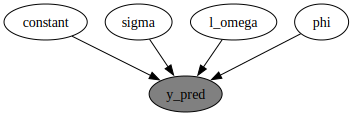

In [10]:
numpyro.render_model(model, model_kwargs={"y": y, "n_lags": 2})

In [11]:
%%time

nuts_kernel = NUTS(model)
mcmc = MCMC(
    nuts_kernel,
    num_warmup=1_000,
    num_samples=2_000,
    num_chains=4,
)

# Run inference
rng_key, rng_subkey = random.split(rng_key)
mcmc.run(rng_subkey, y=y, n_lags=2)

# Get samples
samples = mcmc.get_samples()

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

CPU times: user 2min 45s, sys: 1.3 s, total: 2min 46s
Wall time: 44.2 s


In [12]:
idata = az.from_numpyro(
    mcmc,
    coords={"var_1": data.columns, "var_2": data.columns, "lag": range(2, 0, -1)},
    dims={
        "constant": ["vars"],
        "sigma": ["vars"],
        "l_omega": ["var_1", "var_2"],
        "phi": ["lag", "var_1", "var_2"],
    },
)

In [13]:
idata["posterior"]["phi"].mean(dim=["chain", "draw"]).sel(var_1="realgdp", lag=1)

<xarray.DataArray 'phi' (var_2: 3)> Size: 12B
array([-0.2739717 ,  0.67032284,  0.03232601], dtype=float32)
Coordinates:
    var_1    <U7 28B 'realgdp'
  * var_2    (var_2) object 24B 'realgdp' 'realcons' 'realinv'
    lag      int64 8B 1

In [14]:
a = idata["posterior"]["l_omega"].mean(dim=["chain", "draw"])

In [15]:
corr = a.to_numpy() @ a.to_numpy().T
corr

array([[1.        , 0.59797424, 0.74555194],
       [0.59797424, 0.9967448 , 0.12417292],
       [0.74555194, 0.12417292, 0.99617654]], dtype=float32)

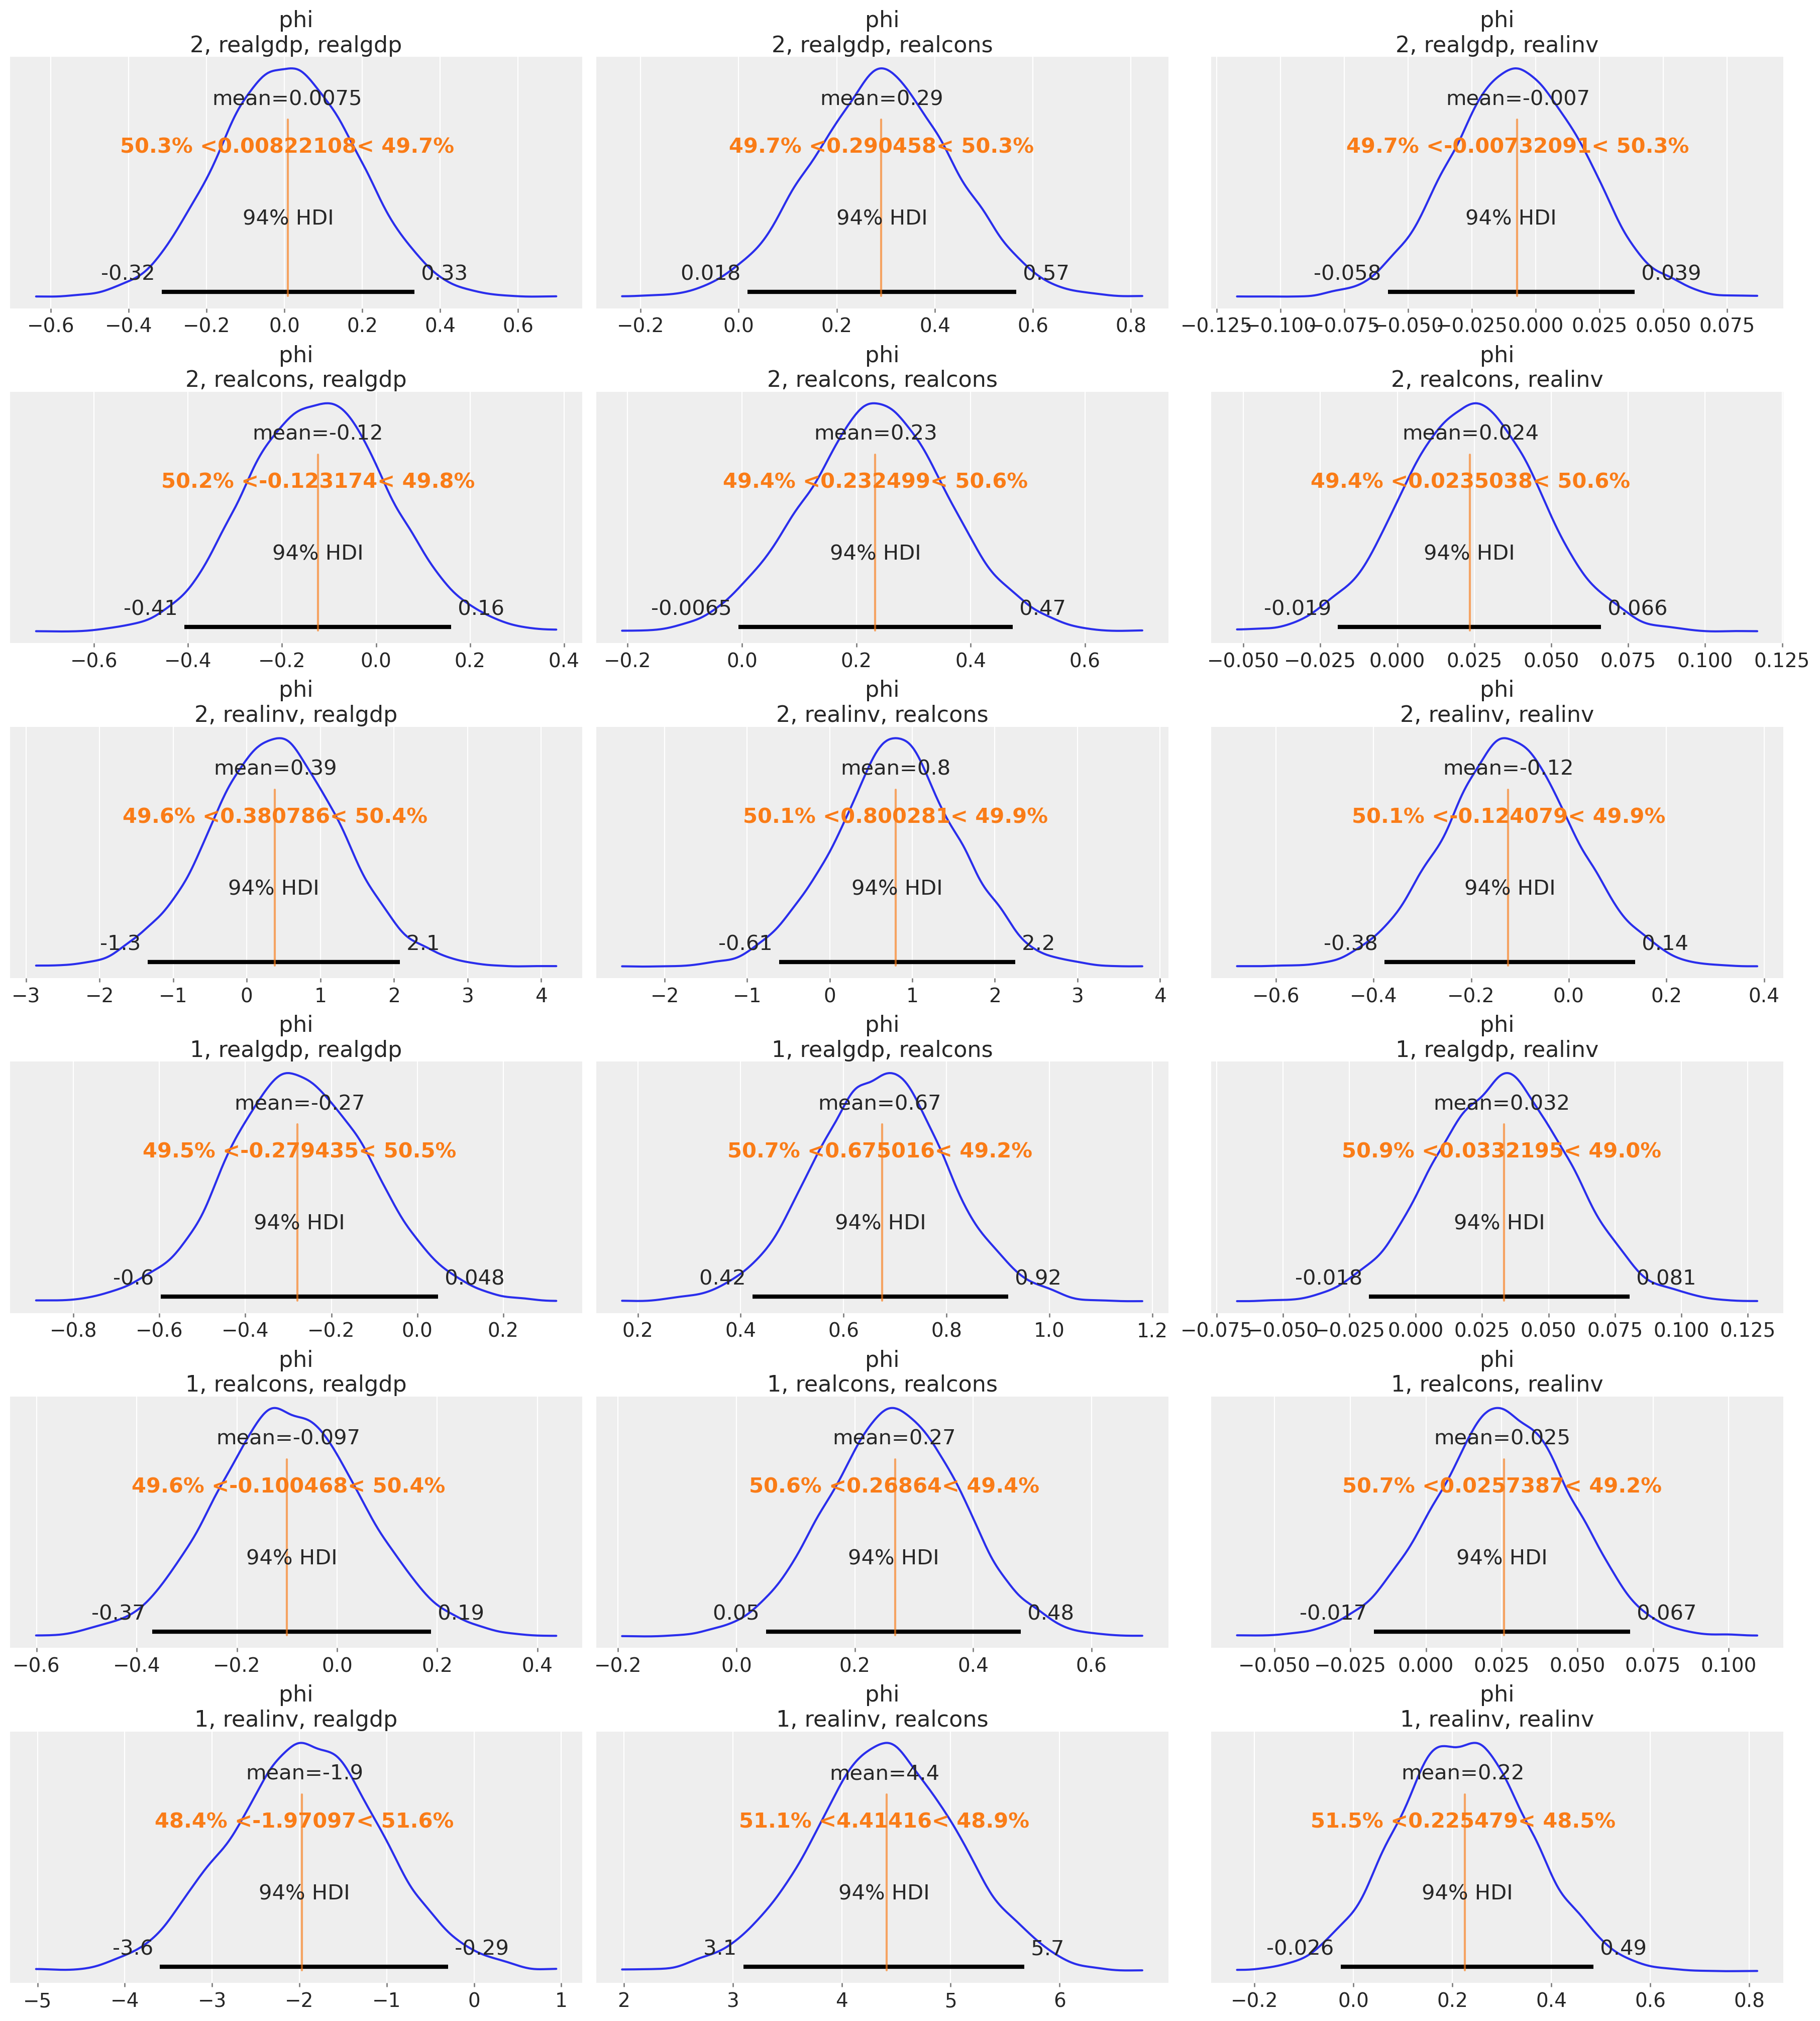

In [16]:
# Reference values from statsmodels VAR(2) results
# Simplified construction using list comprehension and f-strings
lags = [1, 2]
variables = ["realgdp", "realcons", "realinv"]

ref_vals_phi = {
    "phi": [
        {
            "lag": lag,
            "var_1": var_1,
            "var_2": var_2,
            "ref_val": var_results.params[var_1][f"L{lag}.{var_2}"],
        }
        for lag in lags
        for var_1 in variables
        for var_2 in variables
    ]
}

az.plot_posterior(idata, var_names=["phi"], ref_val=ref_vals_phi, figsize=(18, 20));

In [17]:
def compute_irf(
    phi: Float[Array, "n_lags n_vars n_vars"],
    n_steps: int,
    shock_size: float = 1.0,
) -> Float[Array, "n_steps n_vars n_vars"]:
    """
    Compute MA(∞) representation of VAR(p) process (non-orthogonalized IRF).

    Implements the statsmodels ma_rep algorithm using jax.lax.scan:
    Phi_0 = I
    Phi_i = sum_{j=1}^{min(i,p)} Phi_{i-j} @ A_j for i >= 1

    Parameters
    ----------
    phi : array of shape (n_lags, n_vars, n_vars)
        VAR coefficient matrices. phi[j-1] corresponds to A_j.
        IMPORTANT: phi[0] must be lag 1 coefficients, phi[1] must be lag 2, etc.
        If your coords are reversed (e.g., range(2, 0, -1)), you must reverse
        the array before passing it to this function: phi = phi[::-1]
    n_steps : int
        Number of MA coefficient matrices to compute.
    shock_size : float, default=1.0
        Scaling factor for identity matrix at t=0.

    Returns
    -------
    phis : array of shape (n_steps, n_vars, n_vars)
        MA representation. phis[i, :, j] is response of all variables
        at time i to a unit shock to variable j at time 0.
    """
    from jax import lax

    n_lags, n_vars, _ = phi.shape

    def scan_fn(carry, i):
        """
        Compute Phi_i from previous MA matrices.

        carry: Array of shape (n_lags, n_vars, n_vars) containing the last n_lags MA matrices
               carry[0] is Phi_{i-1}, carry[1] is Phi_{i-2}, ..., carry[n_lags-1] is Phi_{i-n_lags}
        i: current time step
        """
        # Compute Phi_i = sum_{j=1}^{min(i,p)} Phi_{i-j} @ A_j
        # We need to handle the case where i < n_lags (early steps)

        # carry[0] is Phi_{i-1}, carry[1] is Phi_{i-2}, etc.
        # phi[0] is A_1 (lag 1), phi[1] is A_2 (lag 2), etc.

        # For each lag j from 1 to min(i, n_lags):
        #   Phi_{i-j} is carry[j-1]
        #   A_j is phi[j-1]

        # Create a mask to only sum over valid lags (up to min(i, n_lags))
        valid_lags = jnp.arange(n_lags) < jnp.minimum(i, n_lags)

        # Compute contributions: Phi_{i-j} @ A_j for each j
        # carry[j] @ phi[j] for j in range(n_lags)
        contributions = jnp.einsum("jkl,jlm->jkm", carry, phi)

        # Mask invalid contributions and sum
        phi_i = jnp.sum(contributions * valid_lags[:, None, None], axis=0)

        # Update carry: shift everything by 1 and add new phi_i at the front
        new_carry = jnp.concatenate([phi_i[None, :, :], carry[:-1]], axis=0)

        return new_carry, phi_i

    # Initialize carry with zeros and set Phi_0 = I at the front
    phi_0 = shock_size * jnp.eye(n_vars)
    init_carry = jnp.concatenate(
        [phi_0[None, :, :], jnp.zeros((n_lags - 1, n_vars, n_vars))], axis=0
    )

    # Run scan for steps 1 to n_steps-1
    if n_steps == 1:
        return phi_0[None, :, :]

    time_steps = jnp.arange(1, n_steps)
    _, phis_rest = lax.scan(scan_fn, init_carry, time_steps)

    # Concatenate Phi_0 with the rest
    phis = jnp.concatenate([phi_0[None, :, :], phis_rest], axis=0)

    return phis

In [18]:
# Verify that the new scan-based implementation matches statsmodels
# Using the exact statsmodels coefficients
phi_sm = jnp.array(var_results.coefs)
n_test_steps = 10

# Compute IRF with scan-based function
irf_jax_scan = compute_irf(phi_sm, n_steps=n_test_steps)

# Get statsmodels IRF (ma_rep)
irf_sm = var_results.ma_rep(maxn=n_test_steps - 1)

# Compare
max_diff = jnp.max(jnp.abs(irf_jax_scan - irf_sm))
print(f"Maximum absolute difference between JAX (scan) and statsmodels: {max_diff:.2e}")

if max_diff < 1e-6:
    print("✓ Scan-based implementation matches statsmodels perfectly!")
else:
    print("✗ Differences detected")
    print(f"\nIRF at t=0 difference:\n{jnp.abs(irf_jax_scan[0] - irf_sm[0])}")
    print(f"\nIRF at t=1 difference:\n{jnp.abs(irf_jax_scan[1] - irf_sm[1])}")


Maximum absolute difference between JAX (scan) and statsmodels: 5.96e-08
✓ Scan-based implementation matches statsmodels perfectly!


In [19]:
# Benchmark: Compare JIT-compiled vs non-JIT performance
from jax import jit
import time

# JIT-compile the function
# Note: n_steps is a static argument (compile-time constant)
compute_irf_jit = jit(compute_irf, static_argnames=["n_steps"])

# Warm-up: First call includes compilation time
print("Warming up JIT compilation...")
_ = compute_irf_jit(phi_sm, n_steps=10)
print("✓ JIT compilation complete!\n")

# Benchmark with a larger number of steps
n_benchmark_steps = 50
n_runs = 100

# Non-JIT version
print("Benchmarking non-JIT version...")
start = time.time()
for _ in range(n_runs):
    _ = compute_irf(phi_sm, n_steps=n_benchmark_steps)
time_no_jit = (time.time() - start) / n_runs

# JIT version
print("Benchmarking JIT version...")
start = time.time()
for _ in range(n_runs):
    _ = compute_irf_jit(phi_sm, n_steps=n_benchmark_steps)
    _.block_until_ready()  # Wait for GPU/TPU computation to finish
time_jit = (time.time() - start) / n_runs

# Results
print(f"\n{'=' * 60}")
print(f"PERFORMANCE COMPARISON ({n_benchmark_steps} IRF steps)")
print(f"{'=' * 60}")
print(f"Non-JIT version: {time_no_jit * 1000:.3f} ms per call")
print(f"JIT version:     {time_jit * 1000:.3f} ms per call")
print(f"Speedup:         {time_no_jit / time_jit:.1f}x faster with JIT")
print(f"\n✓ Use compute_irf_jit for production code!")

print("\n" + "=" * 60)
print("ADVANTAGES OF SCAN + JIT:")
print("=" * 60)
print("  1. Significant speedup (typically 10-50x faster)")
print("  2. Memory efficient (no intermediate array storage)")
print("  3. Better for automatic differentiation if needed")
print("  4. Can be vmapped over multiple posterior samples")
print("  5. Idiomatic JAX code")


Warming up JIT compilation...
✓ JIT compilation complete!

Benchmarking non-JIT version...
Benchmarking JIT version...

PERFORMANCE COMPARISON (50 IRF steps)
Non-JIT version: 27.186 ms per call
JIT version:     0.332 ms per call
Speedup:         81.8x faster with JIT

✓ Use compute_irf_jit for production code!

ADVANTAGES OF SCAN + JIT:
  1. Significant speedup (typically 10-50x faster)
  2. Memory efficient (no intermediate array storage)
  3. Better for automatic differentiation if needed
  4. Can be vmapped over multiple posterior samples
  5. Idiomatic JAX code


In [21]:
# Advanced: Compute IRFs for ALL posterior samples using vmap
# This is useful for uncertainty quantification
from jax import vmap

# Get all posterior samples (flatten chain and draw dimensions)
phi_samples = idata["posterior"]["phi"].stack(sample=["chain", "draw"]).values
# Reverse lag order for all samples
phi_samples = phi_samples[::-1, :, :, :]  # Shape: (n_lags, n_vars, n_vars, n_samples)

# Transpose to get samples as first dimension
phi_samples = jnp.transpose(
    phi_samples, (3, 0, 1, 2)
)  # Shape: (n_samples, n_lags, n_vars, n_vars)

print(f"Phi samples shape: {phi_samples.shape}")
print(f"Number of posterior samples: {phi_samples.shape[0]}")

# Create a vmapped version that computes IRF for each posterior sample
# vmap over the first axis (samples)
compute_irf_vmap = vmap(compute_irf_jit, in_axes=(0, None, None))

# Compute IRFs for all samples at once!
print(f"\nComputing IRFs for all {phi_samples.shape[0]} posterior samples...")
n_irf_steps = 10
irf_samples = compute_irf_vmap(phi_samples, n_irf_steps, 1.0)

print(f"IRF samples shape: {irf_samples.shape}")
print(
    f"Shape: (n_samples={irf_samples.shape[0]}, n_steps={irf_samples.shape[1]}, n_vars={irf_samples.shape[2]}, n_vars={irf_samples.shape[3]})"
)

# Compute credible intervals
irf_mean_vmap = irf_samples.mean(axis=0)
irf_lower = jnp.percentile(irf_samples, 5, axis=0)
irf_upper = jnp.percentile(irf_samples, 95, axis=0)

print(f"\n✓ Successfully computed IRFs with uncertainty bands!")
print(f"\nYou can now plot IRFs with credible intervals:")
print(f"  - irf_mean_vmap: posterior mean IRF")
print(f"  - irf_lower: 5th percentile")
print(f"  - irf_upper: 95th percentile")


Phi samples shape: (8000, 2, 3, 3)
Number of posterior samples: 8000

Computing IRFs for all 8000 posterior samples...
IRF samples shape: (8000, 10, 3, 3)
Shape: (n_samples=8000, n_steps=10, n_vars=3, n_vars=3)

✓ Successfully computed IRFs with uncertainty bands!

You can now plot IRFs with credible intervals:
  - irf_mean_vmap: posterior mean IRF
  - irf_lower: 5th percentile
  - irf_upper: 95th percentile


In [22]:
# Test IRF computation with posterior mean
phi_mean = idata["posterior"]["phi"].mean(dim=["chain", "draw"]).values
l_omega_mean = idata["posterior"]["l_omega"].mean(dim=["chain", "draw"]).values
sigma_mean = idata["posterior"]["sigma"].mean(dim=["chain", "draw"]).values

# IMPORTANT: Reverse lag order! The coords were defined as range(2, 0, -1) which is [2, 1]
# So phi_mean[0] is lag 2 and phi_mean[1] is lag 1, but compute_irf expects
# phi[0] = lag 1, phi[1] = lag 2
phi_mean = phi_mean[::-1]  # Reverse the lag dimension

# Construct the Cholesky factor
l_sigma_mean = sigma_mean[:, None] * l_omega_mean

# Compute IRF for 10 steps
n_irf_steps = 10
irf_mean = compute_irf(phi_mean, n_steps=n_irf_steps)

print(f"IRF shape: {irf_mean.shape}")
print(f"IRF at t=0 (initial shock):\n{irf_mean[0]}")
print(f"\nIRF at t=1:\n{irf_mean[1]}")

IRF shape: (10, 3, 3)
IRF at t=0 (initial shock):
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]

IRF at t=1:
[[-0.2739717   0.67032284  0.03232601]
 [-0.09696127  0.26644838  0.0251097 ]
 [-1.9419706   4.3913403   0.22130677]]


/var/folders/wj/wjy2vm8d7_j9v43bv29zcgl80000gq/T/ipykernel_46391/3589152788.py:28: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


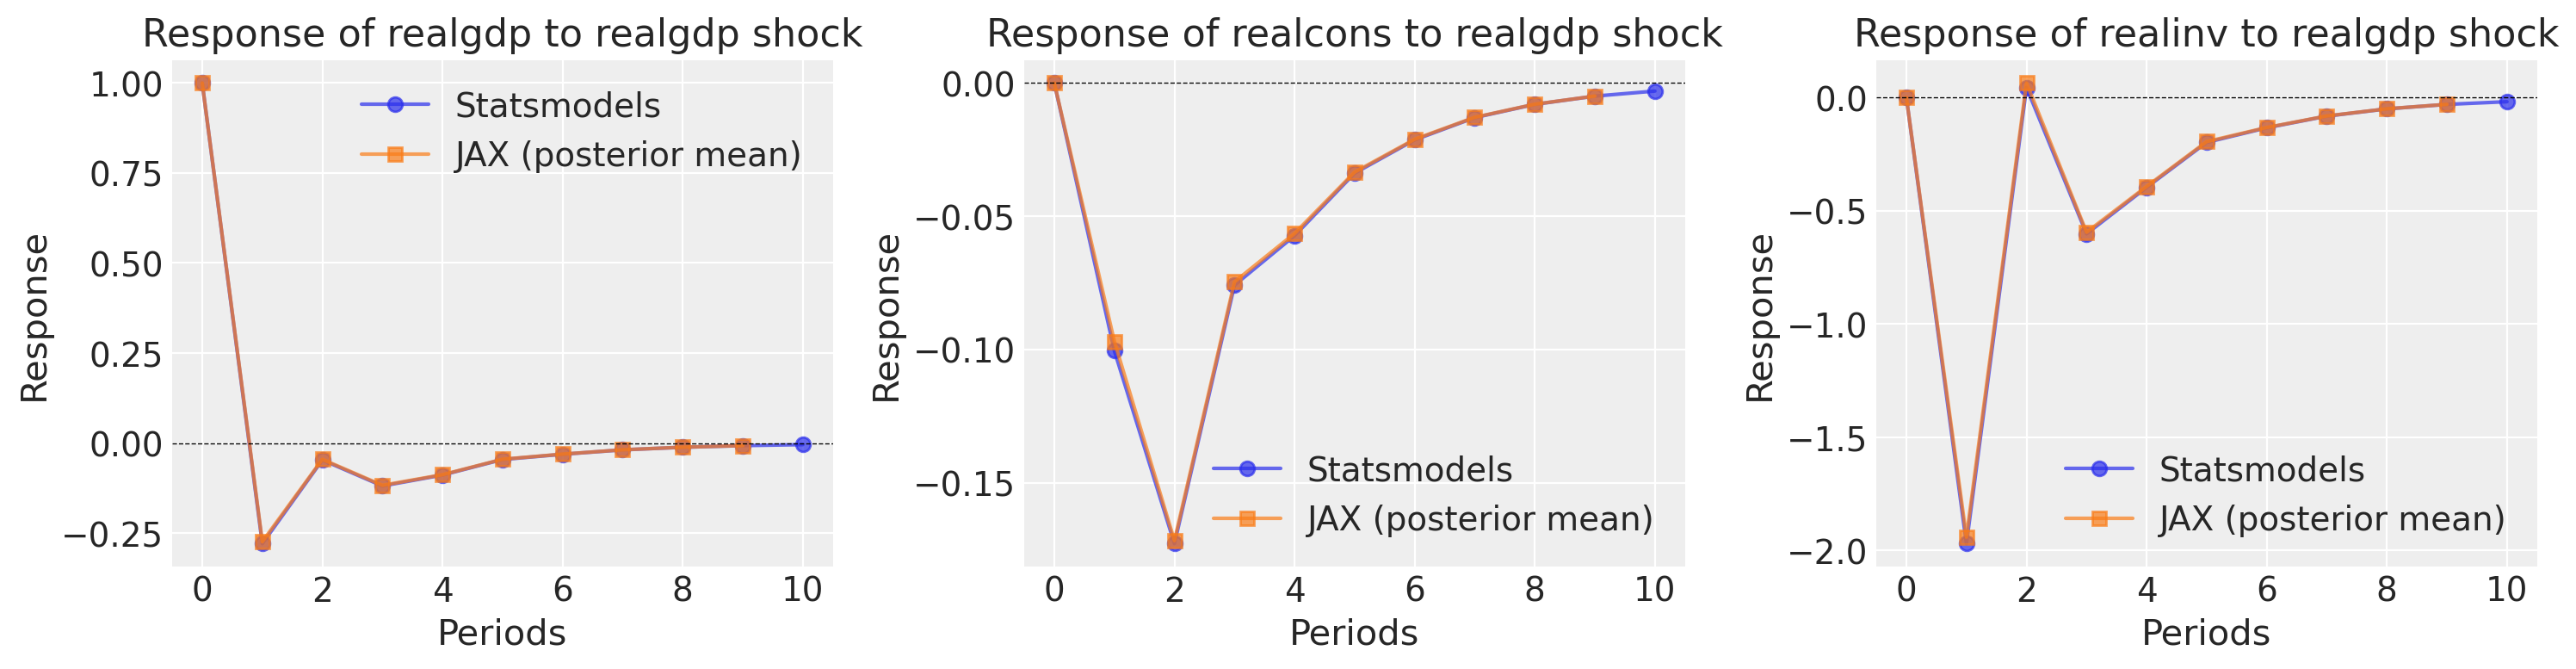

In [23]:
# Compare with statsmodels IRF
var_irf = var_results.irf(n_irf_steps)

# Plot comparison for a specific shock -> response pair
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

shock_var = "realgdp"
response_vars = ["realgdp", "realcons", "realinv"]
shock_idx = list(data.columns).index(shock_var)

for i, response_var in enumerate(response_vars):
    response_idx = list(data.columns).index(response_var)

    # Statsmodels IRF
    sm_irf = var_irf.irfs[:, response_idx, shock_idx]

    # Our JAX IRF (posterior mean)
    jax_irf = irf_mean[:, response_idx, shock_idx]

    axes[i].plot(sm_irf, label="Statsmodels", marker="o", alpha=0.7)
    axes[i].plot(jax_irf, label="JAX (posterior mean)", marker="s", alpha=0.7)
    axes[i].axhline(0, color="black", linestyle="--", linewidth=0.5)
    axes[i].set_title(f"Response of {response_var} to {shock_var} shock")
    axes[i].set_xlabel("Periods")
    axes[i].set_ylabel("Response")
    axes[i].legend()

plt.tight_layout()
plt.show()